This document is intended for intermediate to advanced users. It deals with the internals of the `MoveStrategy` and `MoveScheme` objects, as well how to create custom versions of them. For most users, the default behaviors are sufficient.

In [1]:
%matplotlib inline
import openpathsampling as paths
from IPython.display import SVG, HTML
import openpathsampling.visualize as vis

import openpathsampling.analysis.move_strategy as strategies # TODO: handle this better

In [2]:
def ipynb_visualize(movevis):
    """Default settings to show a movevis in an ipynb."""
    view = movevis.renderer
    view.zoom = 1.5
    view.scale_y = 18
    view.scale_th = 20
    view.font_size = 0.4
    return view

In [3]:
# real fast setup of a small network
from openpathsampling import VolumeFactory as vf
cvA = paths.CV_Function(name="xA", f=lambda s : s.xyz[0][0])
cvB = paths.CV_Function(name="xB", f=lambda s : -s.xyz[0][0])
stateA = paths.CVRangeVolume(cvA, float("-inf"), -0.5)
stateB = paths.CVRangeVolume(cvB, float("-inf"), -0.5)
interfacesA = vf.CVRangeVolumeSet(cvA, float("-inf"), [-0.5, -0.3, -0.1, 0.0])
interfacesB = vf.CVRangeVolumeSet(cvB, float("-inf"), [-0.5, -0.3, -0.1, 0.0])
network = paths.MSTISNetwork([
    (stateA, interfacesA, cvA),
    (stateB, interfacesB, cvB)
])

# `MoveStrategy` and `MoveScheme`

After you've set up your ensembles, you need to create a scheme to sample those ensembles. This is done by the `MoveStrategy` and `MoveScheme` objects.

OpenPathSampling uses a simple default scheme for any network, in which first you choose a type of move to do (shooting, replica exchange, etc), and then you choose a specific instance of that move type (i.e., which ensembles to use). This default scheme works for most cases, but you might find yourself in a situation where the default scheme isn't very efficient, or where you think you have an idea for a more efficient scheme. OpenPathSampling makes it easy to modify the underlying move scheme.

#### Definitions of terms

* **move scheme**: for a given simulation, the move scheme is the "move decision tree". Every step of the MC is done by starting with some root move, and tracing a series of decision points to generate (and then accept) a trial.
* **move strategy**: a general approach to building a move scheme (or a subset thereof). SRTIS is a move strategy. Nearest-neighbor replica exchange is a move strategy. All-replica exchange is a move strategy.

So we use "strategy" to talk about the general idea, and "scheme" to talk about a specific implementation of that idea. This document will describe both how to modify the default scheme for one-time modifications and how to develop new move strategies to be re-used on many problems.

For the simplest cases, you don't need to get into all of this. All you need to do is to use the `DefaultScheme`, getting the move decision tree as follows:

In [4]:
# move_decision_tree = paths.DefaultScheme(network).move_decision_tree()
scheme = paths.DefaultScheme(network)
scheme.movers = {} # TODO: this will be removed, and lines on either side combined, when all is integrated
move_decision_tree = scheme.move_decision_tree()
all_ensembles = network.all_ensembles

OpenPathSampling comes with a nice tool to visualize the move scheme. There are two main columns in the output of this visualization: at the left, you see a visualization of the move decision tree. On the right, you see the input and output ensembles for each `PathMover`.

The move decision tree part of the visualization should be read as follows: each `RandomChoiceMover` (or related movers, such as `OneWayShooting`) randomly select one of the movers at the next level of indentation. Any form of `SequentialMover` performs the moves at the next level of indentation in the order from top to bottom.

The input/output ensembles part shows possible input ensembles to the move marked with a green bar at the top, and possible output ensembles to the move marked with a red bar on the bottom.

The example below shows this visualization for the default scheme with this network.

In [8]:
reload(vis)
def showMTB(mover, ensembles):
    """Show a MoveTree
    """
    mtb = vis.MoveTreeBuilder()
    mtb.set_ensembles(ensembles)
    mtb.set_mover(mover)
    return SVG(mtb.render().tostring())

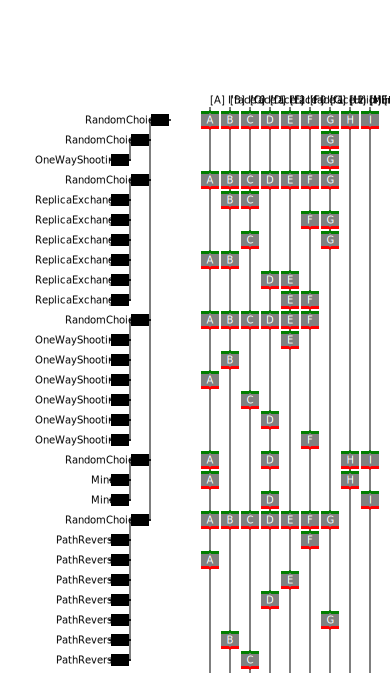

In [10]:
showMTB(move_decision_tree, all_ensembles)

## `MoveScheme`s are built from `MoveStrategy` objects

In the end, you must give your `PathSimulator` object a single `MoveScheme`. However, this scheme might involve several different strategies (for example, whether you want to do one-way shooting or two-way shooting is one strategy decision, and it each can be combined with either nearest-neightbor replica exchange strategy or all-replica exchange strategy: these strategy decisions are completely independent.)


### Creating a strategy

A strategy should be thought of as a way to either add new `PathMover`s to a `MoveScheme` or to change those `PathMover`s which already exist in some way.

Every `MoveStrategy` therefore has an `ensembles` parameter. If the `ensembles` parameter is not given, it is assumed that the user intended all normal ensembles in the scheme's transitions. Every strategy also has an initialization parameter called `group`. This defines the "category" of the move. There are several standard categories (described below), but you can also create custom categories (some examples are given later).

Finally, there is another parameter which can be given in the initialization of any strategy, but which *must* be given as a named parameter. This is `replace`, which is a boolean stating whether the movers created using this should replace those in the scheme at this point.


### Strategy groups

Intuitively, we often think of moves in groups: the shooting moves, the replica exchange moves, etc. For organizational and analysis purposes, we include that structure in the `MoveScheme`, and each `MoveStrategy` must declare what groups it applies to. OpenPathSampling allows users to define arbitrary groups (using strings as labels). The standard schemes use the following groups:

* `'shooting'`
* `'repex'`
* `'pathreversal'`
* `'minus'`


### Strategy levels

In order to apply the strategies in a reasonable order, OpenPathSampling distinguishes several levels at which move strategies work. For example, one level determines which swaps define the replica exchange strategy to be used (`SIGNATURE`), and another level determines whether the swaps are done as replica exchange or ensemble hopping (`GROUP`). Yet another level creates the structures that determine when to do a replica exchange vs. when to do a shooting move (`GLOBAL`).

When building the move decision tree, the strategies are applied in the order of their levels. Each level is given a  numerical value, meaning that it is simple to create custom orderings. Here are the built-in levels, their numeric values, and brief description:

* `levels.SIGNATURE = 10`: 
* `levels.MOVER = 30`: 
* `levels.GROUP = 50`: 
* `levels.SUPERGROUP = 70`: 
* `levels.GLOBAL = 90`: 

### Applying the strategy to a move scheme

To add a strategy to the move scheme, you use `MoveScheme`'s `.append()` function. This function can take two arguments: the list of items to append (which is required) and the `levels` associated with each item. By default, every strategy has a level associated with it, so under most circumstances you don't need to use the `levels` argument.

Now let's look at a specific example. Say that, instead of doing nearest-neighbor replica exchange (as is the default), we wanted to allow all exchanges within each transition. This is as easy as appending an `AllSetRepExStrategy` to our scheme.

In [11]:
# example: switching between AllSetRepEx and NearestNeighborRepEx
scheme = paths.DefaultScheme(network)
scheme.movers = {} # TODO: this will be removed, and lines on either side combined, when all is integrated
scheme.append(strategies.AllSetRepExStrategy())
move_decision_tree = scheme.move_decision_tree()

Now when we visualize this, note the difference in the replica exchange block: we have 6 movers instead of 4, and now we allow the exchanges between the innermost and outermost ensembles.

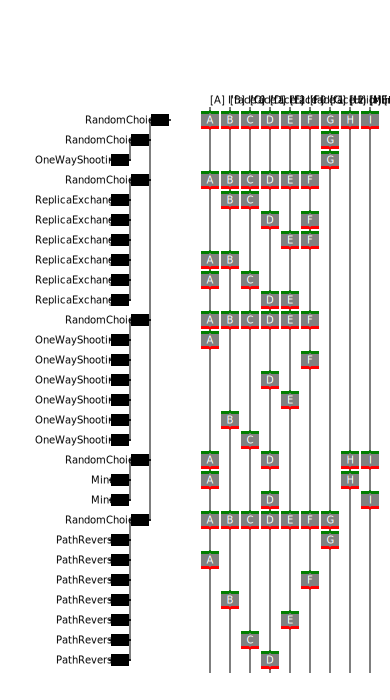

In [12]:
showMTB(move_decision_tree, all_ensembles)

What if you changed your mind, or wanted to go the other way? Of course, you could just create a new scheme from scratch. However, you can also append a `NearestNeighborRepExStrategy` *after* the `AllSetRepExStrategy` and, from that, return to nearest-neighbor replica exchange.

For `NearestNeighborRepExStrategy`, the default is `replace=True`: this is required in order to replace the `AllSetRepExStrategy`. Also, to obtain the new move decision tree, you have to pass the argument `rebuild=True`. This is because, once you've built the tree once, the function `scheme.mover_decision_tree()` will otherwise skip building the scheme and return the root of the already-built decision tree. This allows advanced custom changes, as discussed much later in this document.

In [13]:
scheme.append(strategies.NearestNeighborRepExStrategy())
move_decision_tree = scheme.move_decision_tree(rebuild=True)

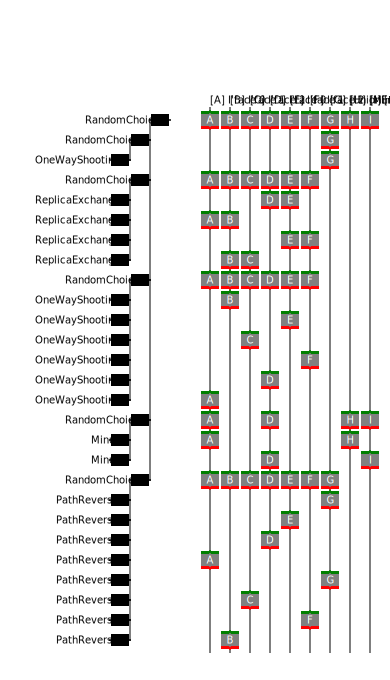

In [14]:
showMTB(move_decision_tree, all_ensembles)

## Combination strategies

OpenPathSampling provides a few shortcuts to strategies which combine several substrategies into a whole.

### `DefaultMoveStrategy`

The `DefaultMoveStrategy` converts the move scheme to one which follows the default OpenPathSampling behavior.

TODO: note that this isn't always the same as the default scheme you get from an empty move scheme. If other movers exist, they are converted to the default strategy. So if you added movers which are not part of the default for your network, they will still get included in the scheme.

### `SingleReplicaStrategy`

The `SingleReplicaStrategy` converts all replica exchanges to ensemble hops (`bias` parameter required). It then reshapes the move decision tree so that is organized by ensemble, TODO

In [15]:
# example: single replica

## Examples of practical uses

In the examples above, we saw how to change from nearest neighbor replica exchange to all (in-set) replica exchange, and we saw how to switch to a single replica move strategy. In the next examples, we'll look at several other uses for move strategies.

### Adding a specific extra replica exchange move

In the examples above, we showed how to get either a nearest neighbor replica exchange attempt graph, or an all in-set replica exchange attempt graph. If you want something in-between, there's also the `NthNearestNeighborRepExStrategy`, which works like those above. But what if (probably in addition to one of these schemes) you want to allow a certain few replica exchange? For example, in a multiple interface set approach you might want to include a few exchanges between interfaces in different sets which share the same initial state.

To do this, we start with an acceptable strategy (we'll assume the default `NearestNeighborRepExStrategy` is our starting point) and we add more moves using `SelectedPairsRepExStrategy`, with `replace=False`.

In [16]:
ens00 = network.sampling_transitions[0].ensembles[0]
ens02 = network.sampling_transitions[0].ensembles[2]
extra_repex = strategies.SelectedPairsRepExStrategy(ensembles=[ens00, ens02], replace=False)
scheme = paths.DefaultScheme(network)
scheme.movers = {} # TODO: this will be removed, and lines on either side combined, when all is integrated
scheme.append(extra_repex)
move_decision_tree = scheme.move_decision_tree()

Now we have 5 replica exchange movers, as can be seen in the move tree visualization.

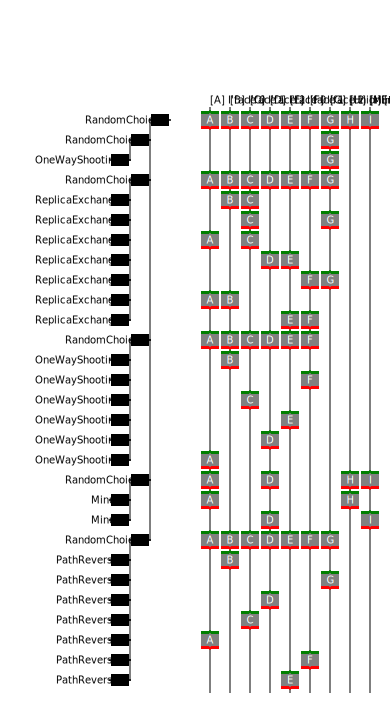

In [17]:
showMTB(move_decision_tree, all_ensembles)

### First crossing shooting point selection for some ensembles

For ensembles which are far from the state, sometimes uniform shooting point selection doesn't work. If the number of frames inside the interface is much larger than the number outside the interface, then you are very likely to select a shooting point inside the interface. If that point is far enough from the interface, it may be very unlikely for the trial path to cross the interface.

One remedy for this is to use the first frame after the first crossing of the interface as the shooting point. This leads to 100% acceptance of the shooting move (every trial satisfies the ensemble, and since there is only one such point -- which is conserved in the trial -- the selection probability is equal in each direction.)

The downside of this approach is that the paths decorrelate much more slowly, since only that one point is allowed for shooting (path reversal moves change which is the "first" crossing, otherwise there would be never be complete decorrelation). So while it may be necessary to do it for outer interfaces, doing the same for inner interfaces may slow convergence. 

The trick we'll show here is to apply the first crossing shooting point selection only to the outer interfaces. This can increase the acceptance probability of the outer interfaces without affecting the decorrelation of the inner interfaces.

In [18]:
# select the outermost ensemble in each sampling transition
special_ensembles = [transition.ensembles[-1] for transition in network.sampling_transitions]

alternate_shooting = strategies.OneWayShootingStrategy(
    selector=paths.UniformSelector(), # TODO: change this
    ensembles=special_ensembles
)
# note that replace=True is the default

scheme = paths.DefaultScheme(network)
scheme.movers = {} # TODO: this will be removed, and lines on either side combined, when all is integrated
scheme.append(alternate_shooting)
move_decision_tree = scheme.move_decision_tree()

In [19]:
# TODO: find a way to visualize

### Two different kinds of shooting for one ensemble

In importance sampling approaches like TIS, you're seeking a balance between two sampling goals. On the one hand, most of space has a negligible (or zero) contribution to the property being measured, so you don't want your steps to be so large that your trials are never accepted. On the other hand, if you make very small steps, it takes a long time to diffuse through the important region (i.e., to decorrelate).

One approach which could be used to fix this would be to allow two different kinds of moves: one which makes small changes with a relatively high acceptance probability to get accepted samples, and one which makes larger changes in an attempt to decorrelate.

This section will show you how to do that by adding a `small_step_shooting` group which does uses the first crossing shooting point selection. (In reality, a better way to get this effect would be to use the standard one-way shooting to do the small steps, and use two-way shooting -- not yet implemented -- to get the larger steps.)

In [20]:
# example: add extra shooting (in a different group, preferably)
extra_shooting = strategies.OneWayShootingStrategy(
    selector=paths.UniformSelector(), # TODO: change this
    group='small_step_shooting'
)
scheme = paths.DefaultScheme(network)
scheme.movers = {} # TODO: this will be removed, and lines on either side combined, when all is integrated
scheme.append(extra_shooting)
move_decision_tree = scheme.move_decision_tree()

In the visualization of this, you'll see that we have 2 blocks of shooting moves: one is the pre-existing group called `'shooting'`, and the other is this new group `'small_step_shooting'`.

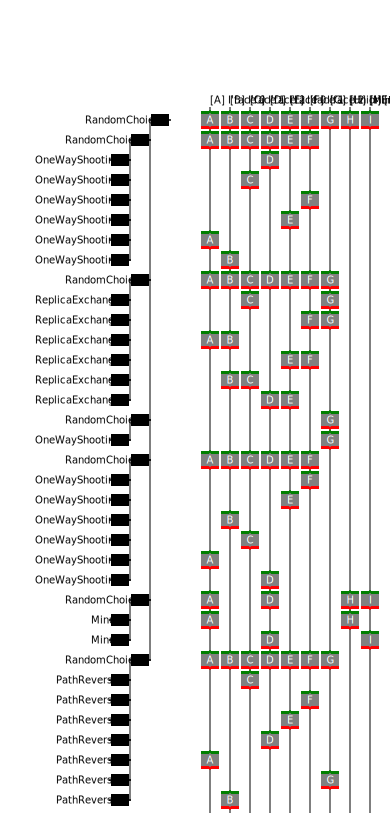

In [22]:
showMTB(move_decision_tree, all_ensembles)

### RepEx-Shoot-RepEx

One of the mains goals of OpenPathSampling is to allow users to develop new approaches. New move strategies certainly represents one direction of possible research. This particular example also shows you how to implement such features. It includes both implementation of a custom `PathMover` and a custom `MoveStrategy`.

Say that, instead of doing the standard replica exchange and shooting moves, you wanted to combine them all into one move buy first doing all the replica exchanges in one order, then doing all the shooting moves, then doing all the replica exchanges in the other order.

To implement this, we'll create a custom subclass of `MoveStrategy`. When making the movers for this strategy, we'll use the built-in `SequentialMover` object to create the move we're interested in.

In [23]:
# example: custom subclass of `MoveStrategy`
class RepExShootRepExStrategy(strategies.MoveStrategy):
    _level = strategies.levels.GROUP
    # we define an init function mainly to set defaults for `replace` and `group`
    def __init__(self, ensembles=None, group="repex_shoot_repex", replace=True, network=None):
        super(RepExShootRepExStrategy, self).__init__(
            ensembles=ensembles, group=group, replace=replace
        )
            
    def make_movers(self, scheme):
        # if we replace, we remove these groups from the scheme.movers dictionary
        if self.replace:
            repex_movers = scheme.movers.pop('repex')
            shoot_movers = scheme.movers.pop('shooting')
        else:
            repex_movers = scheme.movers['repex']
            shoot_movers = scheme.movers['shooting']
        # combine into a list for the SequentialMover
        mover_list = repex_movers + shoot_movers + list(reversed(repex_movers))
        combo_mover = paths.SequentialMover(mover_list)
        return [combo_mover]

In [24]:
repex_shoot_repex = RepExShootRepExStrategy()
scheme = paths.DefaultScheme(network)
scheme.movers = {} # TODO: this will be removed, and lines on either side combined, when all is integrated
scheme.append(repex_shoot_repex)
move_decision_tree = scheme.move_decision_tree()

You'll notice that the `combo_mover` we defined above is within a `RandomChoiceMover`: that random choice is for the group `'repex_shoot_repex'`, which has only this one member.

In this, we have used the default `replace=True`, which removes the old groups for the shooting movers and replica exchange movers. If you would like to keep the old shooting and replica exchange moves around as well, you can use `replace=False`.

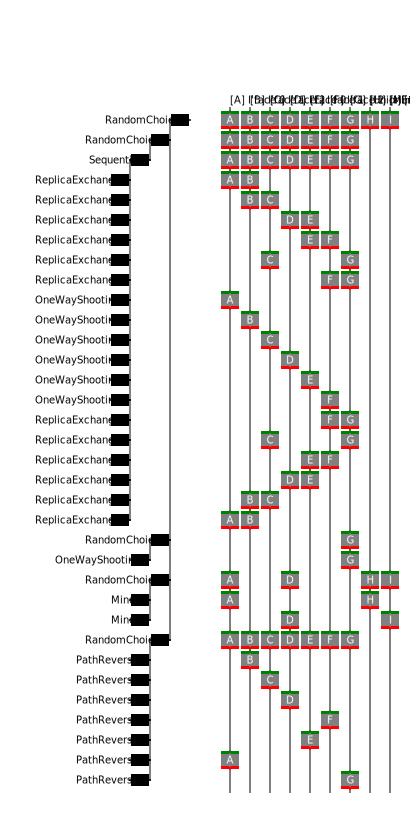

In [25]:
showMTB(move_decision_tree, all_ensembles)

### Modifying the probabilities of moves

The `DefaultStrategy` includes default choices for the probability of making each move type, and then treats all moves within a given type with equal probability. Above, we described how to change the probability of a specific move type; now we're going to discuss changing the probability of a specific move within that type.

One approach would be to create a custom `MoveStrategy` at the `GLOBAL` level. However, in this section we're going to use a different paradigm to approach this problem. Instead of using a `MoveStrategy` to change the `MoveScheme`, we will manually modify it.

Keep in mind that this involves really diving into the guts of the `MoveScheme` object, with all the caveats that involves. Although this paradigm can be used in this and other cases, it is only recommended for advanced users.

One you've created the move decision tree, you can make any custom modifications to it that you would desire. However, it is important to remember that modifying certain aspects can lead to a nonsensical result. For example, appending a move to a `RandomChoiceMover` without also appending an associated `weight` will lead to nonsense. For the most part, it is better to use `MoveStrategy` objects to modify your move decision tree. But to make your own `MoveStrategy` subclasses, you will need to know how to work with the details of the `MoveScheme` and the move decision tree.

In this example, we find the shooting movers associated with a certain ensemble, and double the probability of choosing that ensemble if a shooting move is selected.

In [26]:
# TODO: This is done differently (and more easily) now
# example: getting into the details
#scheme = paths.DefaultScheme(network)
#move_decision_tree = scheme.move_decision_tree()
#ens = network.sampling_transitions[0].ensembles[-1]
#shooting_chooser = [m for m in move_decision_tree.movers if m.movers==scheme.movers['shooting']][0]
#idx_ens = [shooting_chooser.movers.index(m) 
#           for m in shooting_chooser.movers 
#           if m.ensemble_signature==((ens,), (ens,))]
#print shooting_chooser.weights
#for idx in idx_ens:
#    shooting_chooser.weights[idx] *= 2
#print shooting_chooser.weights

## List of built-in `MoveStrategy` classes

#### Replica exchange strategies (`level=SIGNATURE`)

* `NearestNeighborRepExStrategy`
* TODO: `NthNeighborRepExStrategy`
* `AllSetRepExStrategy`
* `SelectedPairsRepExStrategy`


#### Ensemble change strategies (`level=GROUP`)
* TODO: `StateSwapStrategy`
* TODO: `ReplicaExchangeStrategy`
* TODO: `EnsembleHopStrategy`

#### Shooting strategies (`level=MOVER`)

* `OneWayShootingStrategy`
* (`TwoWayShootingStrategy`) : not yet implemented

#### Path reversal strategies (`level=MOVER`)

* `PathReversalStrategy`

#### Minus move strategies (`level=MOVER`)

* TODO: `MinusMoveStrategy`
* TODO: `SingleReplicaMinusStrategy`

#### Overall move decision tree strategies (combinations: `level=GLOBAL`)

* `DefaultMoveStrategy`
* `SingleReplicaStrategy`